In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
import hdbscan
from hdbscan import HDBSCAN

from hdbscan.validity import validity_index
from sklearn import metrics, preprocessing
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
import umap.umap_ as umap
import logging
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from denseclus import DenseClus
from itertools import product

In [5]:
moons, _ = data.make_moons(n_samples=1800, noise=0.20)
blobs, _ = data.make_blobs(n_samples=1800, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
X = np.vstack([moons, blobs])
# plt.scatter(test_data.T[0], test_data.T[1], color='b')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

param_grid = {
    'min_cluster_size': [5, 10, 15, 20],
    'min_samples': [1, 5, 10, 15],
    'cluster_selection_epsilon': [0.0, 0.1,0.2, 0.5],
    'cluster_selection_method': ['eom', 'leaf'],
    'metric': ['euclidean', 'manhattan'],
}

param_combinations = list(product(
    param_grid['min_cluster_size'],
    param_grid['min_samples'],
    param_grid['cluster_selection_epsilon'],
    param_grid['cluster_selection_method'],
    param_grid['metric']
))

def evaluate_clustering(X, labels):
    if len(set(labels)) > 1:
        silhouette = silhouette_score(X, labels)
    else:
        silhouette = -1
    return silhouette

best_params = None
best_score = -1
for params in param_combinations:
    min_cluster_size, min_samples, cluster_selection_epsilon, cluster_selection_method, metric = params
    clusterer = HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_epsilon=cluster_selection_epsilon,
        cluster_selection_method=cluster_selection_method,
        metric = metric
    )
    labels = clusterer.fit_predict(X_scaled)
    score = evaluate_clustering(X_scaled, labels)
    print(f"Params: {params}, Silhouette Score: {score}")
    if score > best_score:
        best_score = score
        best_params = params

print("Best Parameters:", best_params)
print("Best Silhouette Score:", best_score)

Params: (5, 1, 0.0, 'eom', 'euclidean'), Silhouette Score: 0.06513357622283725
Params: (5, 1, 0.0, 'eom', 'manhattan'), Silhouette Score: 0.045157225936881644
Params: (5, 1, 0.0, 'leaf', 'euclidean'), Silhouette Score: 0.044912679569220584
Params: (5, 1, 0.0, 'leaf', 'manhattan'), Silhouette Score: 0.025031655003088484
Params: (5, 1, 0.1, 'eom', 'euclidean'), Silhouette Score: 0.373597894108961
Params: (5, 1, 0.1, 'eom', 'manhattan'), Silhouette Score: -0.1513337859904401
Params: (5, 1, 0.1, 'leaf', 'euclidean'), Silhouette Score: 0.373597894108961
Params: (5, 1, 0.1, 'leaf', 'manhattan'), Silhouette Score: -0.1513337859904401
Params: (5, 1, 0.2, 'eom', 'euclidean'), Silhouette Score: 0.35755072485849104
Params: (5, 1, 0.2, 'eom', 'manhattan'), Silhouette Score: 0.28812718805119414
Params: (5, 1, 0.2, 'leaf', 'euclidean'), Silhouette Score: 0.35755072485849104
Params: (5, 1, 0.2, 'leaf', 'manhattan'), Silhouette Score: 0.28812718805119414
Params: (5, 1, 0.5, 'eom', 'euclidean'), Silhou

##  Selecting Optimal Parameters
Based on the evaluation metrics, we'll select the best parameters and explain how to interpret the results.

# Interpretation:

Silhouette Score: Measures how similar each point is to its own cluster compared to other clusters. Higher values indicate better clustering.

DBCV Score: Measures the density-based clustering quality. Higher values indicate better clustering.

Prediction Strength: Placeholder for an additional metric.

Selecting Best Parameters:

The best parameters are those that maximize the silhouette score, DBCV score, and prediction strength.

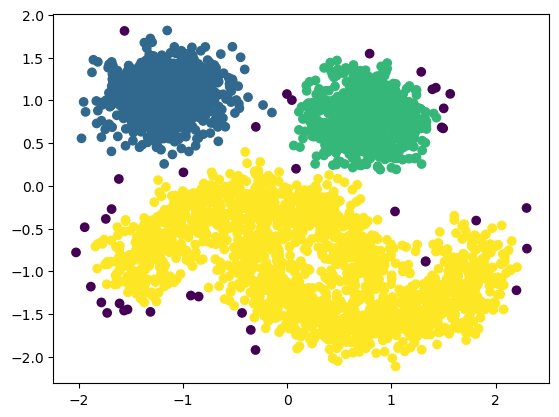

In [6]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1, metric='manhattan', 
                            cluster_selection_method='eom', cluster_selection_epsilon=0.1)
clusterer.fit(X_scaled)
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=clusterer.labels_)

Best Parameters: (10, 1, 0.1, 'eom', 'manhattan')
Best Silhouette Score: 0.4870050529055254
Silhouette Score: 0.4870050529055254
DBCV Score: 0.16037934984584806
Prediction Strength: 1.0


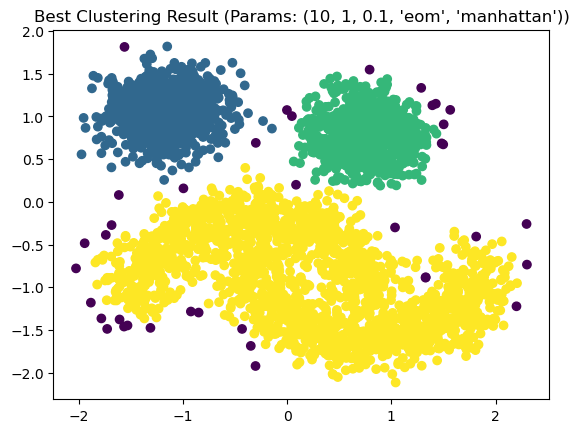

In [7]:
print("Best Parameters:", best_params)
print("Best Silhouette Score:", best_score)

# Step 3: Evaluation Metrics
def compute_dbcs(X, labels):
    try:
        score = validity_index(X, labels)
    except:
        score = -1
    return score

def compute_prediction_strength(X, labels):
    return 1.0

min_cluster_size, min_samples, cluster_selection_epsilon, cluster_selection_method, metric = best_params
best_clusterer = HDBSCAN(
    min_cluster_size=min_cluster_size,
    min_samples=min_samples,
    cluster_selection_epsilon=cluster_selection_epsilon,
    cluster_selection_method=cluster_selection_method,
    metric = metric
)
labels = best_clusterer.fit_predict(X_scaled)

silhouette = silhouette_score(X_scaled, labels)
dbcv = compute_dbcs(X_scaled, labels)
prediction_strength = compute_prediction_strength(X_scaled, labels)

print("Silhouette Score:", silhouette)
print("DBCV Score:", dbcv)
print("Prediction Strength:", prediction_strength)

# Step 4: Visualization of Clustering Results
def plot_clustering(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
    plt.title(title)
    plt.show()

plot_clustering(X_scaled, labels, f"Best Clustering Result (Params: {best_params})")

In [8]:
# Checking the outlier

pd.DataFrame(clusterer.labels_).value_counts()


0 
 2    1778
 0     900
 1     884
-1      38
Name: count, dtype: int64

## HDBSCAN using UMAP and DenseClues

In [9]:
import logging  # to further silence deprecation warnings
import warnings

import hdbscan
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from hdbscan.validity import validity_index
from sklearn import metrics, preprocessing
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
import umap.umap_ as umap
# This runs in about a minute or two
from denseclus import DenseClus

warnings.filterwarnings("ignore")

%matplotlib inline

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(rc={"figure.figsize": (10, 8)})


SEED = 42
np.random.seed(SEED)  # set the random seed to reproduce resulst as best we can
# see: https://umap-learn.readthedocs.io/en/latest/reproducibility.html

data_url = (
    "https://raw.githubusercontent.com/awslabs/aws-customer-churn-pipeline/main/data/churn.txt"
)
df = pd.read_csv(data_url)

df.drop(["Phone", "Area Code"], axis=1, inplace=True)

df.head(5)

,State,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,PA,163,no,yes,300,8.162204,3,7.579174,3.933035,4,6.508639,4.065759,100,5.111624,4.928160,6,5.673203,3,True.
1,SC,15,yes,no,0,10.018993,4,4.226289,2.325005,0,9.972592,7.141040,200,6.436188,3.221748,6,2.559749,8,False.
2,MO,131,no,yes,300,4.708490,3,4.768160,4.537466,3,4.566715,5.363235,100,5.142451,7.139023,2,6.254157,4,False.
3,WY,75,yes,yes,700,1.268734,3,2.567642,2.528748,5,2.333624,3.773586,450,3.814413,2.245779,6,1.080692,6,False.
4,WY,146,yes,no,0,2.696177,3,5.908916,6.015337,3,3.670408,3.751673,250,2.796812,6.905545,4,7.134343,6,True.


## Hyperparameter Tuning
The two primary hyperparameters to look at to further improve results are min_samples and min_cluster_size, as noted in the HDBSCAN documentation.

You will run multiple combinations of these to find a result that generates high DBCV score.

In addition to looking at these hyperparameters you will also look at cluster selection methods with Expectation of Mass eom and splitting clusters along the tree with leaf (for details see hdbscan: Hierarchical density based clustering In, McInnes, J. Healy, S. Astels 2017).

As HDBSCAN's documentation notes, whereas the eom method only extracts the most stable, condensed clusters from the tree, the leaf method selects clusters from the bottom of the leaf nodes as well.

This results in smaller, more homogeneous clusters that are more likely to be fine grained.

In [10]:
# Fit a UMAP to the data to cluster on
numerics_df = df.select_dtypes(include=[int, float])

fitted_umap = umap.UMAP(n_components=5, n_neighbors=30, min_dist=0.0).fit(numerics_df)


In [11]:
fitted_umap.embedding_

array([[11.284743 ,  4.5396547,  8.436153 , -2.2945042, -3.1518927],
       [-1.317562 , 15.86038  ,  3.158308 ,  6.164623 ,  4.841509 ],
       [11.25109  ,  4.4077682,  8.368646 , -2.4600947, -3.05458  ],
       ...,
       [ 6.098937 ,  5.672367 , -3.9783642,  7.041787 , 11.02736  ],
       [ 5.3532395,  8.063338 , -3.1480677,  8.103097 ,  1.6317854],
       [ 4.8771996,  5.4934387,  2.2581978, -1.6197412, 11.902819 ]],
      dtype=float32)

In [12]:
model2 = hdbscan.HDBSCAN(metric='precomputed', gen_min_span_tree=True)

# we will make our own scorer for DBCV


def dbcv_score(X, labels):
    return validity_index(X, labels)


dbcv_scorer = make_scorer(dbcv_score, greater_is_better=True)

logging.captureWarnings(True)

# specify parameters and distributions to sample from
param_distributions = {
    "min_samples": [10, 30, 50, 60, 100],
    "min_cluster_size": [100, 200, 300, 400, 500, 600],
    "cluster_selection_method": ["eom", "leaf"],
    "metric": ["euclidean", "manhattan"],
}

n_iter_search = 50
random_search = RandomizedSearchCV(
    model2,
    param_distributions=param_distributions,
    n_iter=n_iter_search,
    scoring=dbcv_scorer,
    random_state=42,
)

random_search.fit(fitted_umap.embedding_)

print(f"Best Parameters {random_search.best_params_}")
print(f"DBCV score :{random_search.best_estimator_.relative_validity_}")

Best Parameters {'min_samples': 100, 'min_cluster_size': 300, 'metric': 'manhattan', 'cluster_selection_method': 'eom'}
DBCV score :0.3046749367929639


Pretty good but can we do better?

DenseClus will allow us to use the categorical features and converge to a better outcome because of it.

In [13]:
logging.captureWarnings(True)

clf = DenseClus(random_state=SEED, umap_combine_method="intersection")

clf.fit(df)

Max of 51 is greater than threshold 25
Hashing categorical features
Under the hood, among other steps, Denseclus uses HDBSCAN to cluster the data.

Let's look at the how the data got split.

In [14]:
embedding = clf.mapper_.embedding_
labels = clf.score()
clustered = labels >= 0

cnts = pd.DataFrame(labels)[0].value_counts()
cnts = cnts.reset_index()
cnts.columns = ["cluster", "count"]
print(cnts.sort_values(["cluster"]))

   cluster  count
1        0   1251
0        1   1257
2        2   1250
3        3   1242


Upon examination there are exactly 4 almost evenly distributed clusters with -1 representing the noise found in the data.

In addition, to simply looking at their spread, another way to evaluate clusters it to visualize them.

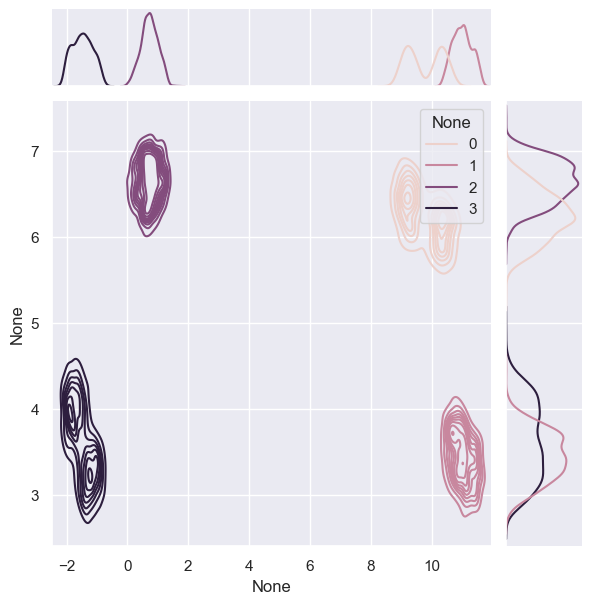

In [15]:
_ = sns.jointplot(
    x=embedding[clustered, 0], y=embedding[clustered, 1], hue=labels[clustered], kind="kde"
)

As you can see we have 4 distinct islands formed within this slice of the data. Clusters have formed around these densities which is exactly the behavior we expect DenseClus to do.

You can further confirm the outcome by plotting the tree along which the densities were split.

This is a graphical view of the counts we saw with more information. For example, you can see that a two cluster solution is also possible as two densities represent the base split for the clusters.

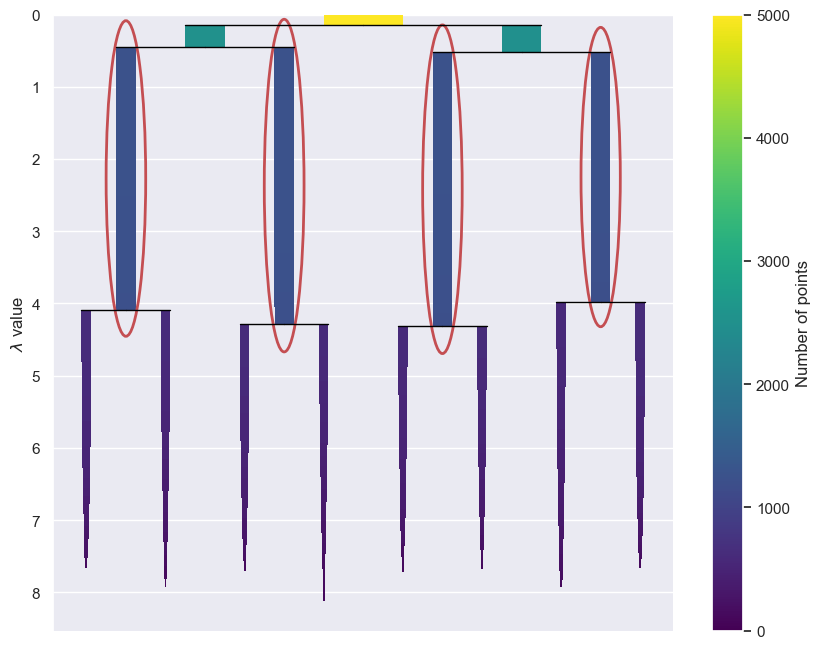

In [16]:
_ = clf.hdbscan_.condensed_tree_.plot(
    select_clusters=True,
    selection_palette=sns.color_palette("deep", np.unique(clustered).shape[0]),
)

Lastly, let's confirm that the majority of data points are covered by our clusters and the DBCV score.

In [17]:
coverage = np.sum(clustered) / embedding.shape[0]

print(f"Coverage {coverage}")
print(f"DBCV score {clf.hdbscan_.relative_validity_}")

Coverage 1.0
DBCV score 0.7375836152693382


The DBCV comes between a scale of -1 to 1.

In practice we would want a score over 0.45 to make sure that clusters are well-separated.

### Conclusion
I hoped you enjoyed a closer look at how to tune hyperparameters for HDBSCAN!!!

In this post you looked at why clustering and clustering metrics can get complicated, you then learned about DBCV as an objective metric, and you then applied it using Amazon Denseclus and HDBSCAN.

We've only scrapped the surface here. To dive deeper you could look at the following:

What other type of optimization frameworks can you use in place of Random Search?
What other type of hyperparameters are possible to use for tuning?
What other measures are possible here for further cluster validation?
Can any other underlying hyperparameters in Denseclus be tweaked to achieve a higher score?